# Applying MLP

#### 1a: Load and preprocess the dataset

In [28]:
# Import packages and libraries
import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from itertools import combinations

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
# Reading in the datasets
file_path = 'data/project_adult.csv'
file_path2 = 'data/project_validation_inputs.csv'

# Converting to dataframes
df_adult = pd.read_csv(file_path, header=0, encoding='utf-8')
df_validation = pd.read_csv(file_path2, header=0, encoding='utf-8')

In [6]:
# Preprocessing - examine missing values
df_adult.replace('?', np.nan, inplace=True)
null_counts = df_adult.isnull().sum()
print(null_counts)

Unnamed: 0           0
age                  0
workclass         1447
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1454
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     458
income               0
dtype: int64


In [7]:
# Make sure the validation set is similar 
df_validation.replace('?', np.nan, inplace=True)
null_counts = df_validation.isnull().sum()
print(null_counts)

Unnamed: 0          0
age                 0
workclass         389
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        389
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    125
dtype: int64


This reveals that we need to handle missing data for workclass, occupation, and native-county, which are all categorical. Because they're all categorical, we can use mode imputation.

In [23]:
# Modified preprocess_data function to handle both training and validation datasets

# Preprocess the dataset: handle missing values, encode categorical features, standardize numerical features, 
# and separate features from target.
def preprocess_data(df, target_column='income', fit_scaler=True, return_split=False, test_size=0.2, random_state=42):
    
    # Global variables to store fitted transformers
    global trained_scaler, trained_encoder, feature_columns
    
    print(f"Original data shape: {df.shape}")
    print(f"Original data columns: {df.columns.tolist()}")

    #####################[ Handle missing values ]#####################

    # Convert ? to null for easier handling
    df.replace('?', np.nan, inplace=True)

    # Use mode imputation to handle missing values in categorical columns
    categorical_cols = df.select_dtypes(include=['object','category']).columns
    print(f"Categorical columns: {categorical_cols.tolist()}\n\n")

    print("MODE IMPUTATION: \n")

    for col in categorical_cols:
        null_count = df[col].isnull().sum()
        print(f"Null count for {col} : {null_count}")
        if null_count > 0:
            col_mode = df[col].mode()[0]
            df[col].fillna(col_mode, inplace=True)
            print(f"-> Imputed '{col}' with mode: {col_mode}")


    #####################[ Encoding features ]#####################

    # Keep track of rows indexes
    df = df.reset_index(drop=True)

    # SEPARATE X AND y ONLY IF target_column IS PROVIDED AND EXISTS
    if target_column is not None and target_column in df.columns:
        y = df[target_column]
        X = df.drop(columns=[target_column])
        print(f"\nAfter separation: \n\tX shape: {X.shape} \n\ty shape: {y.shape}")
    else:
        X = df.copy()
        y = None
        print(f"No target column specified or found. Using all columns as features. X shape: {X.shape}")
    
    # Encode categorical features (only on X, not y)    
    cols_to_encode = [col for col in categorical_cols if col in X.columns]
    
    # Use OneHotEncoder for consistent encoding across datasets
    if 'trained_encoder' not in globals() or fit_scaler:  # If first call or fitting fresh
        trained_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        encoded_array = trained_encoder.fit_transform(X[cols_to_encode])
        encoded_columns = trained_encoder.get_feature_names_out(cols_to_encode)
        
        # Create DataFrame with encoded features
        X_encoded = pd.DataFrame(encoded_array, columns=encoded_columns)
        
        # Drop original categorical columns and add encoded ones
        X = X.drop(columns=cols_to_encode)
        X = pd.concat([X, X_encoded], axis=1)
        
        # Store the feature columns for consistent transformation later
        feature_columns = X.columns.tolist()
    else:
        # Use the pre-fitted encoder
        encoded_array = trained_encoder.transform(X[cols_to_encode])
        encoded_columns = trained_encoder.get_feature_names_out(cols_to_encode)
        
        X_encoded = pd.DataFrame(encoded_array, columns=encoded_columns)
        X = X.drop(columns=cols_to_encode)
        X = pd.concat([X, X_encoded], axis=1)
        
        # Ensure all expected columns are present (fill missing with 0)
        missing_cols = set(feature_columns) - set(X.columns)
        for col in missing_cols:
            X[col] = 0
        
        # Reorder columns to match training data
        X = X[feature_columns]

    print(f"After encoding categorical features X shape: {X.shape}")    

    # Ensure all columns are numeric
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')


    #####################[ Standardization ]#####################

    # Global scaling for ALL features
    if fit_scaler:
        trained_scaler = StandardScaler()
        X = pd.DataFrame(trained_scaler.fit_transform(X), columns=X.columns)
    elif 'trained_scaler' in globals():
        # Use pre-fitted scaler
        X = pd.DataFrame(trained_scaler.transform(X), columns=X.columns)
    
    
    #####################[ Train/test split ]#####################

    if return_split and y is not None:
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        print(f"Train/test split: \n\tX_train: {X_train.shape} \n\tX_test: {X_test.shape}")
        return X_train, X_test, y_train, y_test
    elif return_split and y is None:
        raise ValueError("Cannot return split when no target column is available")
    else:
        if y is not None:
            return X, y
        else:
            return X  # Return only X if no target column

In [29]:
# Preprocess and split data
X_train, X_test, y_train, y_test = preprocess_data(
    df_adult, 
    target_column='income', 
    fit_scaler=True, 
    return_split=True,
    test_size=0.2,
    random_state=42
)

Original data shape: (26048, 16)
Original data columns: ['Unnamed: 0', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']


MODE IMPUTATION: 

Null count for workclass : 0
Null count for education : 0
Null count for marital-status : 0
Null count for occupation : 0
Null count for relationship : 0
Null count for race : 0
Null count for sex : 0
Null count for native-country : 0
Null count for income : 0

After separation: 
	X shape: (26048, 15) 
	y shape: (26048,)
After encoding categorical features X shape: (26048, 98)
Train/test split: 
	X_train: (20838, 98) 
	X_test: (5210, 98)


### 1b: Train and test MLP model on dataset while tuning parameters to develop multiple candidates
### 1c: Evaluate models using appropriate metrics
### 1d: Select most promising model

In [10]:
# DEFINE THE MODEL
    # Hidden layer sizes: 2 hidden layers, 64 and 32 neurons respectively
    # Activation: using default=’relu’
    # Solver: using default=’adam’
    # Alpha: using default=0.0001 (L2 regularization strength)
    # Batch size: using default batch_size=min(200, n_samples) for the size of the minibatches
    # Learning rate init: using default=0.001
    # Max iter: 500
    # Shuffle: using default=True because shuffling samples can help escape local minima
    # Random state: for reproducibility 

mlp1 = MLPClassifier(
    hidden_layer_sizes=(64, 32), 
    max_iter=500, 
    random_state=42)

In [11]:
# Train the model
mlp1.fit(X_train, y_train)

,hidden_layer_sizes,"(64, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,42


In [30]:
# Predict and evaluate
y_pred1 = mlp1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred1)
print(f"Accuracy: {accuracy*100:.2f}%")

class_report = classification_report(y_test, y_pred1)
print("Classification Report:\n", class_report)

Accuracy: 80.58%
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.87      0.88      0.87      3956
        >50K       0.60      0.57      0.59      1254

    accuracy                           0.81      5210
   macro avg       0.73      0.73      0.73      5210
weighted avg       0.80      0.81      0.80      5210



In [13]:
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

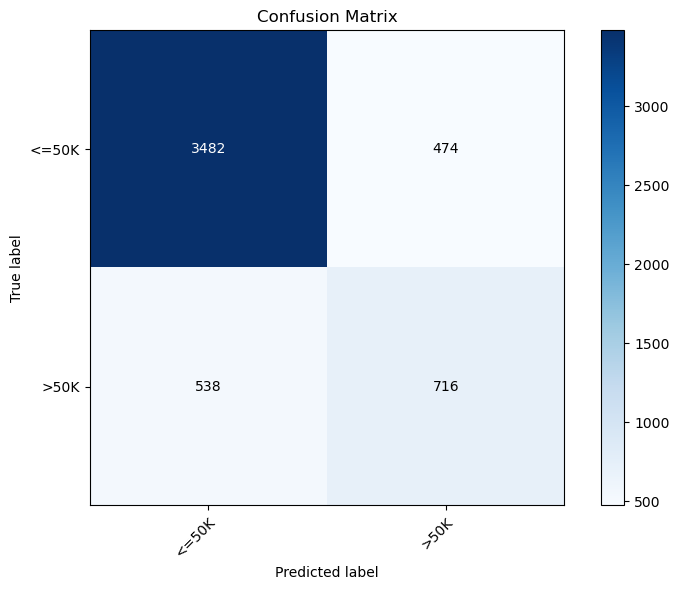

In [14]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred1)
plot_confusion_matrix(cm, y_test)

Not a bad accuracy right off the bat, but there are a lot of hyperparameters to tune. We can use GridSearchCV to help.

#### ⚠️ OPTIONAL: Run Full Hyperparameter Search 

The following cell runs GridSearchCV to find the optimal MLP model parameters. Runtime is approximately 6 hours. To skip this long process, do not run this cell or the one immediately after it. Instead, jump ahead to the "Quick Model Initialization" section.

In [169]:
# Define the estimator
mlp_gs = MLPClassifier(max_iter=500, shuffle=True, random_state=42)
# Keeping constant: 
    # Max iter: 500
    # Shuffle: using default=True because shuffling samples can help escape local minima
    # Random state: for reproducibility 

# Define the parameter options
parameters = {
    'hidden_layer_sizes': [
        (66),           # 2/3 * input layer + output layer = 66 (single layer)
        (44, 22),       # 66 split 2:1 (2 layers)
        (22, 11),       # half of ^
    ],     
    'activation': ['tanh', 'relu'],                      
    'solver': ['sgd', 'adam'],                       
    'alpha': [0.0001, 0.001, 0.01],                 # strength of L2 regularization (helps prevent overfitting)          
    'batch_size': [32, 64, 128],                    # size of the minibatch 
    'learning_rate_init': [0.001, 0.01, 0.05]       # learning rate / step size for updating weights
}

# Define the GridSearch
grid_search = GridSearchCV(
    estimator=mlp_gs,
    param_grid=parameters,
    cv=3,                     # 3-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

# Find best params
print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_train, y_train.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 3 folds for each of 324 candidates, totalling 972 fits


/Users/brynnb/miniconda3/envs/geoenv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brynnb/miniconda3/envs/geoenv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brynnb/miniconda3/envs/geoenv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brynnb/miniconda3/envs/geoenv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged ye

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=500, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'batch_size': [32, 64, 128],
                         'hidden_layer_sizes': [66, (44, 22), (22, 11)],
                         'learning_rate_init': [0.001, 0.01, 0.05],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy', verbose=1)

In [178]:
# Print info about the best model found by GridSearch
print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


--- Best Model Found by GridSearchCV ---
Best parameters: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 32, 'hidden_layer_sizes': (44, 22), 'learning_rate_init': 0.01, 'solver': 'adam'}
Best cross-validation accuracy: 0.8516


#### ✅ Quick Model Initialization (Recommended Bypass) 

If you skipped the previous two cells (the long GridSearchCV block and its results), run this cell. It loads the final MLP model using the pre-determined best hyperparameters and executes in just a few seconds.

```
--- Best Model Found by GridSearchCV ---

Best parameters: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 32, 'hidden_layer_sizes': (44, 22), 'learning_rate_init': 0.01, 'solver': 'adam'}

Best cross-validation accuracy: 0.8516
```

In [31]:
# Define the best model found by GridSearch
best_model = MLPClassifier(
    activation='relu',
    alpha=0.01,
    batch_size=32,
    hidden_layer_sizes=(44, 22), 
    learning_rate_init=0.01,
    solver='adam',
    max_iter=500, 
    shuffle=True,
    random_state=42)

# Train the model
best_model.fit(X_train, y_train)

,hidden_layer_sizes,"(44, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.01
,batch_size,32
,learning_rate,'constant'
,learning_rate_init,0.01
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,42


In [32]:
# Predict and evaluate
y_pred2 = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {accuracy*100:.2f}%")

class_report = classification_report(y_test, y_pred2)
print("Classification Report:\n", class_report)

Accuracy: 84.61%
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      3956
        >50K       0.75      0.54      0.63      1254

    accuracy                           0.85      5210
   macro avg       0.81      0.74      0.77      5210
weighted avg       0.84      0.85      0.84      5210



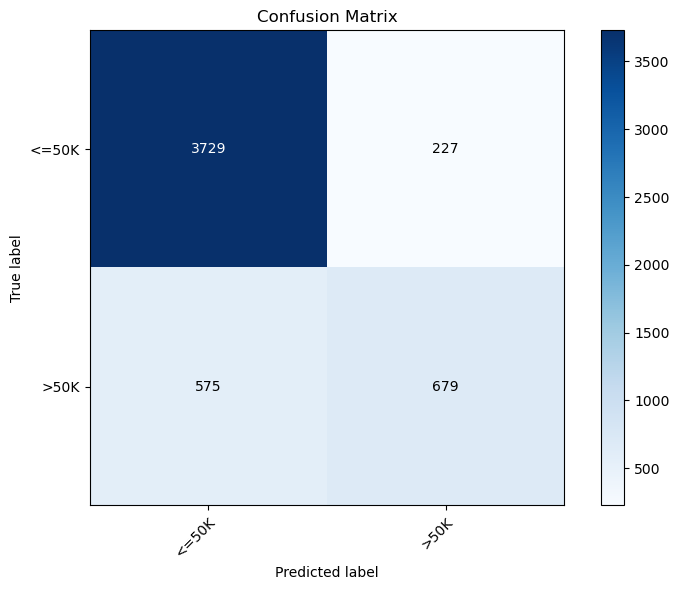

In [33]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred2)
plot_confusion_matrix(cm, y_test)


### 1e. Predict response variable for validation inputs by using most promising model

In [36]:
# Preprocess validation data
X_val = preprocess_data(
    df_validation, 
    target_column=None,      # No 'income' column in validation
    fit_scaler=False,        # Use the already fitted scaler and encoder
    return_split=False       # Don't split validation data
)

Original data shape: (6513, 15)
Original data columns: ['Unnamed: 0', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


MODE IMPUTATION: 

Null count for workclass : 0
Null count for education : 0
Null count for marital-status : 0
Null count for occupation : 0
Null count for relationship : 0
Null count for race : 0
Null count for sex : 0
Null count for native-country : 0
No target column specified or found. Using all columns as features. X shape: (6513, 15)
After encoding categorical features X shape: (6513, 98)


In [40]:
# Predict response variable for validation inputs by using most promising model
y_pred3 = best_model.predict(X_val)

# Since validation data doesn't have true labels in competitions
# we can just display the predictions and their distribution:
print(f"Validation Predictions Shape: {y_pred3.shape}")
print(f"First 10 Validation Predictions: {y_pred3[:10]}")

# Show prediction distribution
unique, counts = np.unique(y_pred3, return_counts=True)
print("\nValidation Prediction Distribution:")
for label, count in zip(unique, counts):
    percentage = (count / len(y_pred3)) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

# Print total number of predictions
print(f"\nValidation predictions completed: {len(y_pred3)} predictions made")

Validation Predictions Shape: (6513,)
First 10 Validation Predictions: ['<=50K' '>50K' '>50K' '<=50K' '<=50K' '>50K' '>50K' '<=50K' '<=50K'
 '<=50K']

Validation Prediction Distribution:
  <=50K: 5347 (82.1%)
  >50K: 1166 (17.9%)

Validation predictions completed: 6513 predictions made


In [44]:
# Check if features have different distributions
# Compare key feature distributions between train and validation
print("Feature Distribution Comparison:")
numerical_features = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']
for feature in numerical_features:
    if feature in X_train.columns:
        train_mean = X_train[feature].mean()
        val_mean = X_val[feature].mean()
        diff = abs(train_mean - val_mean)
        print(f"{feature}: Train mean={train_mean:.3f}, Val mean={val_mean:.3f}, Diff={diff:.3f}")

Feature Distribution Comparison:
age: Train mean=-0.000, Val mean=0.002, Diff=0.002
education-num: Train mean=0.001, Val mean=0.000, Diff=0.001
hours-per-week: Train mean=0.001, Val mean=0.020, Diff=0.019
capital-gain: Train mean=-0.004, Val mean=0.017, Diff=0.021
capital-loss: Train mean=0.004, Val mean=-0.008, Diff=0.012


In [45]:
# Implement the threshold adjustment
from sklearn.metrics import classification_report

# Get prediction probabilities
if hasattr(best_model, 'predict_proba'):
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
    
    # Test different thresholds to address conservative predictions
    thresholds = [0.3, 0.4, 0.5, 0.6]
    print("Threshold Analysis to Address Distribution Shift:")
    
    for threshold in thresholds:
        # Apply threshold adjustment
        y_val_adjusted = (y_val_proba >= threshold).astype(int)
        y_val_pred_adjusted = best_model.classes_[y_val_adjusted]
        
        # Calculate new distribution
        pos_percentage = (y_val_pred_adjusted == '>50K').mean() * 100
        print(f"Threshold {threshold}: {pos_percentage:.1f}% >50K predictions")
        
        # Show how this compares to expected ~24%
        if abs(pos_percentage - 24) < 3:  # Close to expected 24%
            print(f"  → Threshold {threshold} gives distribution close to expected!")
            best_threshold = threshold

Threshold Analysis to Address Distribution Shift:
Threshold 0.3: 27.9% >50K predictions
Threshold 0.4: 21.7% >50K predictions
  → Threshold 0.4 gives distribution close to expected!
Threshold 0.5: 17.9% >50K predictions
Threshold 0.6: 13.6% >50K predictions


In [46]:
# Simple probability calibration analysis
print("\nCalibration Analysis:")
y_val_proba = best_model.predict_proba(X_val)[:, 1]

# Analyze probability distribution
prob_bins = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
for i in range(len(prob_bins)-1):
    low, high = prob_bins[i], prob_bins[i+1]
    count = ((y_val_proba >= low) & (y_val_proba < high)).sum()
    percentage = (count / len(y_val_proba)) * 100
    print(f"Probabilities {low:.1f}-{high:.1f}: {count} samples ({percentage:.1f}%)")

# If most probabilities are in low ranges, model is conservative
low_prob_count = (y_val_proba < 0.3).sum()
print(f"\nSamples with probability < 0.3: {low_prob_count} ({low_prob_count/len(y_val_proba)*100:.1f}%)")


Calibration Analysis:
Probabilities 0.0-0.1: 3155 samples (48.4%)
Probabilities 0.1-0.3: 1544 samples (23.7%)
Probabilities 0.3-0.5: 648 samples (9.9%)
Probabilities 0.5-0.7: 549 samples (8.4%)
Probabilities 0.7-0.9: 382 samples (5.9%)
Probabilities 0.9-1.0: 235 samples (3.6%)

Samples with probability < 0.3: 4699 (72.1%)


In [47]:
# Apply the optimal threshold to fix distribution shift
if 'best_threshold' in locals():
    print(f"\nApplying optimal threshold {best_threshold} to validation predictions...")
    y_val_final = (y_val_proba >= best_threshold).astype(int)
    y_val_pred_final = best_model.classes_[y_val_final]
    
    final_pos_percentage = (y_val_pred_final == '>50K').mean() * 100
    print(f"Final validation distribution: {final_pos_percentage:.1f}% >50K")
    
    # Save the improved predictions
    validation_output = pd.DataFrame({
        'Predicted_Income': [1 if pred == '>50K' else -1 for pred in y_val_pred_final]
    })
    validation_output.to_csv('Group_22_MLP_PredictedOutputs.csv', index=False)
    print("Improved predictions saved!")


Applying optimal threshold 0.4 to validation predictions...
Final validation distribution: 21.7% >50K
Improved predictions saved!
